In [6]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import talos
from talos.utils import lr_normalizer
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.activations import relu, elu
from tensorflow.keras.losses import mean_squared_error
from talos.utils import hidden_layers
import math

In [ ]:
def save_df(dataframe, filename): # save a dataframe to a csv file
    # writing to csv file
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object
        csvwriter = csv.writer(csvfile,lineterminator='\n')

        # writing the fields
        csvwriter.writerow(dataframe.columns) 

        # writing the data rows 
        csvwriter.writerows(np.array(dataframe))

# Load and prepare the dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Hackathon/yellow_cab_data.csv') # Read in data

# convert N to 0, Y to 1

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('N', 0)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('Y', 1)

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_1.csv')

In [ ]:
labels = list(df.columns)

row_index = 0

while row_index < len(df): # convert each date into a float
    for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        date = df[col].iloc[row_index]
        date = date.split() # date splits into 2022-01-01 and 00:27:45
        first_half = date[0].split('-') # 2022-01-01 splits into 2022, 01, 01
        year = int(first_half[0]) # 2022
        month = int(first_half[1]) # 01
        day = int(first_half[2]) # 01

        second_half = date[1].split(':') # 00:27:45 splits into 00, 27, 45
        hour = int(second_half[0]) # 00
        min = int(second_half[1]) # 27
        sec = int(second_half[2]) # 45

        date_float = (year - 2022) * 365.25 + (month - 1) * 30.437 + (day - 1) + (hour / 24.0) + (min / (24.0 * 60)) + (sec / (24.0 * 3600))
        df.at[row_index, col] = date_float

    row_index += 1

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_2.csv')

# to create new predictions, we have to split the dataset roughly 50 to 50
# take the first half and split it into training and test
# then make predictions on the second half of the dataset

'''
mid = int(len(df) / 2)
X = df['fare_amount'].iloc[:mid]
Y = df['fare_amount'].iloc[mid:]
X = np.array(X)
Y = np.array(Y)
'''

mid = int(len(df) / 2)
X_tot = df.drop('fare_amount',axis=1)
X_tot = np.asarray(X_tot).astype('float32')
Y_tot = df['fare_amount']

X = X_tot[0:mid]
Y = Y_tot[0:mid]

X_generate = X_tot[mid:]

print(X.shape)
print(Y.shape)

(75000, 18)
(75000,)


In [ ]:
# split dataset into train, validation, test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state = 42)

params = {'learning_rate': 0.1, # learning rate [0.1,0.3,0.5]
          'first_hidden_layer':8, # neurons in first layer
          'second_hidden_layer':8, # neurons in second layer
          'third_hidden_layer':8, # neurons in third layer [8,16,32,64]
          'batch_size': 30, # batch size [5,10,50]
          'epochs': 150, # number of epochs
          'dropout': 0.3, # percentage of input that is ignored
          'optimizer': Adam, # methods of gradient descent
          'losses': mean_squared_error, # cost function
          'activation':relu, # maps the layer's input to output
          'last_activation': None,
          'weight_regulizer': None,
          'emb_output_dims': None}

'''
optimizer = dp_optimizer.DPGradientDescentGaussianOptimizer(
          l2_norm_clip=FLAGS.l2_norm_clip,
          noise_multiplier=FLAGS.noise_multiplier,
          num_microbatches=FLAGS.microbatches,
          learning_rate=FLAGS.learning_rate)
'''

if True:
    # create model
    model = Sequential()

    # input layer and 1st hidden layer
    model.add(Dense(units=params['first_hidden_layer'], input_dim=train_X.shape[1], 
                    activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer
    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer 
    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # output layer
    model.add(Dense(units=1, activation=params['last_activation'], 
                    kernel_initializer='normal'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=params['optimizer'](lr=lr_normalizer(params['learning_rate'],params['optimizer'])),
                  metrics=keras.metrics.mean_squared_error)

    # train model
    history = model.fit(x=train_X,
                        y=train_Y, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)
    
    Y_generate = model.predict(X_generate)

'''
TESTING TALOS HYPERPARAMETER OPTIMIZATION

def keras_model(x_train,y_train,x_val,y_val,params):

    # create model
    model = Sequential()

    # input layer and 1st hidden layer
    model.add(Dense(units=params['first_hidden_layer'], input_dim=1, 
                    activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer
    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer 
    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # output layer
    model.add(Dense(units=1, activation=params['last_activation'], 
                    kernel_initializer='normal'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=keras.metrics.mean_squared_error)

    # train model
    history = model.fit(x=x_train,
                        y=y_train, 
                        validation_data=(x_val,y_val),
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)

    return history,model

# set parameter space

p = {'lr': [0.1, 0.3, 0.5], # learning rate [0.1,0.3,0.5]
     'first_hidden_layer':[8, 16, 32, 64, 128], # neurons in first layer
     'second_hidden_layer':[8, 16, 32, 64], # neurons in second layer
     'third_hidden_layer':[8, 16, 32, 64], # neurons in third layer [8,16,32,64]
     'batch_size': (2, 30, 10), # batch size [5,10,50]
     'epochs': [150], # number of epochs
     'dropout': [0.3, 0.5], # percentage of input that is ignored
     'optimizer': [Adam], # methods of gradient descent
     'losses': [mean_squared_error], # cost function
     'activation':[relu], # maps the layer's input to output
     'last_activation': [None],
     'weight_regulizer':[None],
     'emb_output_dims': [None]}

# run the experiment
scan_object = talos.Scan(x=train_X,
                         y=train_Y,
                         val_split = 0.25,
                         model=keras_model,
                         params=p,
                         experiment_name='Talos_Optimization',
                         fraction_limit=.01)
'''

2344/2344 [==============================] - 3s 1ms/step


"\ndef keras_model(x_train,y_train,x_val,y_val,params):\n\n    # create model\n    model = Sequential()\n\n    # input layer and 1st hidden layer\n    model.add(Dense(units=params['first_hidden_layer'], input_dim=1, \n                    activation=params['activation'], \n                    kernel_initializer='normal'))\n\n    # dropout layer\n    model.add(Dropout(params['dropout']))\n\n    # hidden layer\n    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], \n                    kernel_initializer='normal'))\n\n    # dropout layer\n    model.add(Dropout(params['dropout']))\n\n    # hidden layer \n    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],\n                    kernel_initializer='normal'))\n\n    # dropout layer\n    model.add(Dropout(params['dropout']))\n\n    # output layer\n    model.add(Dense(units=1, activation=params['last_activation'], \n                    kernel_initializer='normal'))\n\n    #

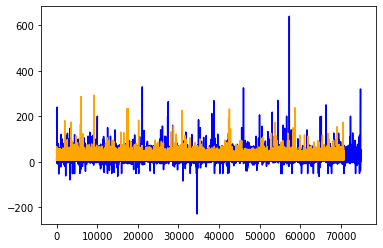

Mean in Data: 12.858080533333265
Mean in Generated: 12.117890877981871
Median in Data: 9.0
Median in Generated: 7.3224316
Standard Deviation in Data: 13.107143091242827
Standard Deviation in Generated: 10.09883646877305
Variance in Data: 171.79720001431457
Variance in Generated: 101.98649802302052


In [ ]:
from typing import SupportsComplex
import matplotlib.pyplot as plt
import statistics
import math

def mean(items):
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += item
      count += 1
  return sum / count

def stdev(items):
  mean1 = mean(items)
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += pow(item-mean1,2)
      count += 1
  var = sum / count
  std = math.sqrt(var)  # standard deviation
  return std

plt.plot(Y,color='blue')
plt.plot(Y_generate,color='orange') # orange is the extrapolated data
plt.show()

# mean, median, standard deviation, variance
Y_generate = pd.DataFrame(Y_generate)

# save_df(Y_generate,'/content/drive/MyDrive/Data Science Hackathon/test_3.csv')

mean_data = mean(Y)
mean_gen = mean(Y_generate.values)

print("Mean in Data: " + str(mean_data))
print("Mean in Generated: " + str(mean_gen[0]))

median_data = statistics.median(Y)
median_gen = statistics.median(Y_generate.values)

print("Median in Data: " + str(median_data))
print("Median in Generated: " + str(median_gen[0]))

stdev_data = statistics.stdev(Y)
stdev_gen = stdev(Y_generate.values)

print("Standard Deviation in Data: " + str(stdev_data))
print("Standard Deviation in Generated: " + str(stdev_gen))

var_data = statistics.stdev(Y) * statistics.stdev(Y)
var_gen = stdev(Y_generate.values) * stdev(Y_generate.values)

print("Variance in Data: " + str(var_data))
print("Variance in Generated: " + str(var_gen))

In [4]:
# %pip install tensorflow-privacy

from tensorflow_privacy.privacy.optimizers import dp_optimizer

In [10]:
# NOW TESTING THE TIP AMT

def save_df(dataframe, filename): # save a dataframe to a csv file
    # writing to csv file
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object
        csvwriter = csv.writer(csvfile,lineterminator='\n')

        # writing the fields
        csvwriter.writerow(dataframe.columns) 

        # writing the data rows 
        csvwriter.writerows(np.array(dataframe))

# Load and prepare the dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Hackathon/yellow_cab_data.csv') # Read in data

# convert N to 0, Y to 1

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('N', 0)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('Y', 1)

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_1.csv')

In [11]:
labels = list(df.columns)

row_index = 0

while row_index < len(df): # convert each date into a float
    for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        date = df[col].iloc[row_index]
        date = date.split() # date splits into 2022-01-01 and 00:27:45
        first_half = date[0].split('-') # 2022-01-01 splits into 2022, 01, 01
        year = int(first_half[0]) # 2022
        month = int(first_half[1]) # 01
        day = int(first_half[2]) # 01

        second_half = date[1].split(':') # 00:27:45 splits into 00, 27, 45
        hour = int(second_half[0]) # 00
        min = int(second_half[1]) # 27
        sec = int(second_half[2]) # 45

        date_float = (year - 2022) * 365.25 + (month - 1) * 30.437 + (day - 1) + (hour / 24.0) + (min / (24.0 * 60)) + (sec / (24.0 * 3600))
        df.at[row_index, col] = date_float

    row_index += 1

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_2.csv')

# might need to convert strings into floats here
# to create new predictions, we have to split the dataset roughly 50 to 50
# take the first half and split it into training and test
# then make predictions on the second half of the dataset

'''
mid = int(len(df) / 2)
X = df['fare_amount'].iloc[:mid]
Y = df['fare_amount'].iloc[mid:]
X = np.array(X)
Y = np.array(Y)
'''

mid = int(len(df) / 2)
X_tot = df.drop('tip_amount',axis=1)
X_tot = np.asarray(X_tot).astype('float32')
Y_tot = df['tip_amount']

X = X_tot[0:mid]
Y = Y_tot[0:mid]

X_generate = X_tot[mid:]

print(X.shape)
print(Y.shape)

(75000, 18)
(75000,)


In [12]:
# split dataset into train, validation, test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state = 42)

params = {'learning_rate': 0.1, # learning rate [0.1,0.3,0.5]
          'first_hidden_layer':8, # neurons in first layer
          'second_hidden_layer':8, # neurons in second layer
          'third_hidden_layer':8, # neurons in third layer [8,16,32,64]
          'batch_size': 30, # batch size [5,10,50]
          'epochs': 150, # number of epochs
          'dropout': 0.3, # percentage of input that is ignored
          'optimizer': Adam, # methods of gradient descent
          'losses': mean_squared_error, # cost function
          'activation':relu, # maps the layer's input to output
          'last_activation': None,
          'weight_regulizer': None,
          'emb_output_dims': None}

if True:
    # create model
    model = Sequential()

    # input layer and 1st hidden layer
    model.add(Dense(units=params['first_hidden_layer'], input_dim=train_X.shape[1], 
                    activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer
    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer 
    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # output layer
    model.add(Dense(units=1, activation=params['last_activation'], 
                    kernel_initializer='normal'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=params['optimizer'](lr=lr_normalizer(params['learning_rate'],params['optimizer'])),
                  metrics=keras.metrics.mean_squared_error)

    # train model
    history = model.fit(x=train_X,
                        y=train_Y, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=1)
    
    Y_generate = model.predict(X_generate)

Epoch 1/150
2000/2000 [==============================] - 6s 2ms/step - loss: 6.4596 - mean_squared_error: 6.4596
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 5.5501 - mean_squared_error: 5.5501
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 4.5533 - mean_squared_error: 4.5533
Epoch 4/150
2000/2000 [==============================] - 5s 2ms/step - loss: 3.4301 - mean_squared_error: 3.4301
Epoch 5/150
2000/2000 [==============================] - 6s 3ms/step - loss: 3.3844 - mean_squared_error: 3.3844
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 2.7498 - mean_squared_error: 2.7498
Epoch 7/150
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6032 - mean_squared_error: 2.6032
Epoch 8/150
2000/2000 [==============================] - 4s 2ms/step - loss: 2.4004 - mean_squared_error: 2.4004
Epoch 9/150
2000/2000 [==============================] - 6s 3ms/step - loss: 2.4098 - mean_squar

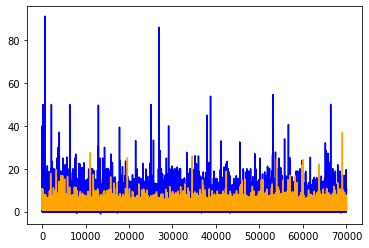

Mean in Data: 2.367622266666619
Mean in Generated: 1.8967060655552257
Median in Data: 2.0
Median in Generated: 1.7668502
Standard Deviation in Data: 2.796618665829092
Standard Deviation in Generated: 1.1479778517018713
Variance in Data: 7.82107596206369
Variance in Generated: 1.3178531479980435


In [14]:
from typing import SupportsComplex
import matplotlib.pyplot as plt
import statistics
import math

def mean(items):
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += item
      count += 1
  return sum / count

def stdev(items):
  mean1 = mean(items)
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += pow(item-mean1,2)
      count += 1
  var = sum / count
  std = math.sqrt(var)  # standard deviation
  return std

plt.plot(Y[0:70000],color='blue')
plt.plot(Y_generate[0:70000],color='orange') # orange is the extrapolated data
plt.show()

# mean, median, standard deviation, variance
Y_generate = pd.DataFrame(Y_generate)

# save_df(Y_generate,'/content/drive/MyDrive/Data Science Hackathon/test_3.csv')

mean_data = mean(Y)
mean_gen = mean(Y_generate.values)

print("Mean in Data: " + str(mean_data))
print("Mean in Generated: " + str(mean_gen[0]))

median_data = statistics.median(Y)
median_gen = statistics.median(Y_generate.values)

print("Median in Data: " + str(median_data))
print("Median in Generated: " + str(median_gen[0]))

stdev_data = statistics.stdev(Y)
stdev_gen = stdev(Y_generate.values)

print("Standard Deviation in Data: " + str(stdev_data))
print("Standard Deviation in Generated: " + str(stdev_gen))

var_data = statistics.stdev(Y) * statistics.stdev(Y)
var_gen = stdev(Y_generate.values) * stdev(Y_generate.values)

print("Variance in Data: " + str(var_data))
print("Variance in Generated: " + str(var_gen))

In [19]:
# PRINT THE CORRELATION

tempName = "tip_amount"

col2 = Y[0:70000]

print(Y_generate[0:70000].corrwith(col2))

0   -0.003076
dtype: float64


In [21]:
# NOW TESTING THE PAYMENT_TYPE

def save_df(dataframe, filename): # save a dataframe to a csv file
    # writing to csv file
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object
        csvwriter = csv.writer(csvfile,lineterminator='\n')

        # writing the fields
        csvwriter.writerow(dataframe.columns) 

        # writing the data rows 
        csvwriter.writerows(np.array(dataframe))

# Load and prepare the dataset

df = pd.read_csv('/content/drive/MyDrive/Data Science Hackathon/yellow_cab_data.csv') # Read in data

# convert N to 0, Y to 1

df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('N', 0)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].replace('Y', 1)

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_1.csv')

In [22]:
labels = list(df.columns)

row_index = 0

while row_index < len(df): # convert each date into a float
    for col in ['tpep_pickup_datetime', 'tpep_dropoff_datetime']:
        date = df[col].iloc[row_index]
        date = date.split() # date splits into 2022-01-01 and 00:27:45
        first_half = date[0].split('-') # 2022-01-01 splits into 2022, 01, 01
        year = int(first_half[0]) # 2022
        month = int(first_half[1]) # 01
        day = int(first_half[2]) # 01

        second_half = date[1].split(':') # 00:27:45 splits into 00, 27, 45
        hour = int(second_half[0]) # 00
        min = int(second_half[1]) # 27
        sec = int(second_half[2]) # 45

        date_float = (year - 2022) * 365.25 + (month - 1) * 30.437 + (day - 1) + (hour / 24.0) + (min / (24.0 * 60)) + (sec / (24.0 * 3600))
        df.at[row_index, col] = date_float

    row_index += 1

# save_df(df,'/content/drive/MyDrive/Data Science Hackathon/test_2.csv')

'''
mid = int(len(df) / 2)
X = df['fare_amount'].iloc[:mid]
Y = df['fare_amount'].iloc[mid:]
X = np.array(X)
Y = np.array(Y)
'''

mid = int(len(df) / 2)
X_tot = df.drop('payment_type',axis=1)
X_tot = np.asarray(X_tot).astype('float32')
Y_tot = df['payment_type']

X = X_tot[0:mid]
Y = Y_tot[0:mid]

X_generate = X_tot[mid:]

print(X.shape)
print(Y.shape)

(75000, 18)
(75000,)


In [23]:
# split dataset into train, validation, test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state = 42)

params = {'learning_rate': 0.1, # learning rate [0.1,0.3,0.5]
          'first_hidden_layer':8, # neurons in first layer
          'second_hidden_layer':8, # neurons in second layer
          'third_hidden_layer':8, # neurons in third layer [8,16,32,64]
          'batch_size': 30, # batch size [5,10,50]
          'epochs': 150, # number of epochs
          'dropout': 0.3, # percentage of input that is ignored
          'optimizer': Adam, # methods of gradient descent
          'losses': mean_squared_error, # cost function
          'activation':relu, # maps the layer's input to output
          'last_activation': None,
          'weight_regulizer': None,
          'emb_output_dims': None}

if True:
    # create model
    model = Sequential()

    # input layer and 1st hidden layer
    model.add(Dense(units=params['first_hidden_layer'], input_dim=train_X.shape[1], 
                    activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer
    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer 
    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # output layer
    model.add(Dense(units=1, activation=params['last_activation'], 
                    kernel_initializer='normal'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=params['optimizer'](lr=lr_normalizer(params['learning_rate'],params['optimizer'])),
                  metrics=keras.metrics.mean_squared_error)

    # train model
    history = model.fit(x=train_X,
                        y=train_Y, 
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=1)
    
    Y_generate = model.predict(X_generate)

Y_generate = np.around(Y_generate)

Epoch 1/150
2000/2000 [==============================] - 5s 2ms/step - loss: 0.2746 - mean_squared_error: 0.2746
Epoch 2/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1120 - mean_squared_error: 0.1120
Epoch 3/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1131 - mean_squared_error: 0.1131
Epoch 4/150
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0911 - mean_squared_error: 0.0911
Epoch 5/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0951 - mean_squared_error: 0.0951
Epoch 6/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0933 - mean_squared_error: 0.0933
Epoch 7/150
2000/2000 [==============================] - 5s 3ms/step - loss: 0.1006 - mean_squared_error: 0.1006
Epoch 8/150
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0888 - mean_squared_error: 0.0888
Epoch 9/150
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0859 - mean_squar

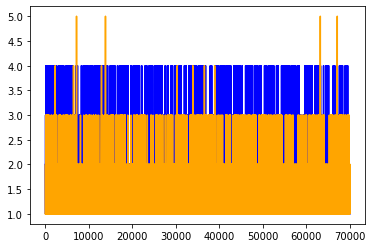

Mean in Data: 1.2414266666666667
Mean in Generated: 1.23244106958526
Median in Data: 1.0
Median in Generated: 1.0
Standard Deviation in Data: 0.46952043329485244
Standard Deviation in Generated: 0.4367733860901274
Variance in Data: 0.22044943728138597
Variance in Generated: 0.19077099079663548


In [24]:
from typing import SupportsComplex
import matplotlib.pyplot as plt
import statistics
import math

def mean(items):
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += item
      count += 1
  return sum / count

def stdev(items):
  mean1 = mean(items)
  sum = 0
  count = 0
  for item in items:
    if not math.isnan(item):
      sum += pow(item-mean1,2)
      count += 1
  var = sum / count
  std = math.sqrt(var)  # standard deviation
  return std

plt.plot(Y[0:70000],color='blue')
plt.plot(Y_generate[0:70000],color='orange') # orange is the extrapolated data
plt.show()

# mean, median, standard deviation, variance
Y_generate = pd.DataFrame(Y_generate)

# save_df(Y_generate,'/content/drive/MyDrive/Data Science Hackathon/test_3.csv')

mean_data = mean(Y)
mean_gen = mean(Y_generate.values)

print("Mean in Data: " + str(mean_data))
print("Mean in Generated: " + str(mean_gen[0]))

median_data = statistics.median(Y)
median_gen = statistics.median(Y_generate.values)

print("Median in Data: " + str(median_data))
print("Median in Generated: " + str(median_gen[0]))

stdev_data = statistics.stdev(Y)
stdev_gen = stdev(Y_generate.values)

print("Standard Deviation in Data: " + str(stdev_data))
print("Standard Deviation in Generated: " + str(stdev_gen))

var_data = statistics.stdev(Y) * statistics.stdev(Y)
var_gen = stdev(Y_generate.values) * stdev(Y_generate.values)

print("Variance in Data: " + str(var_data))
print("Variance in Generated: " + str(var_gen))

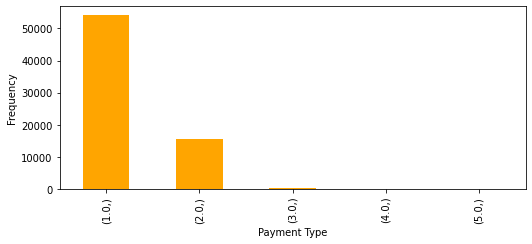

In [30]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

col = Y_generate[0:70000]

df = pd.DataFrame(col)
df.value_counts().plot(ax=ax , kind='bar', xlabel='Payment Type', ylabel='Frequency',color='orange')

plt.show()

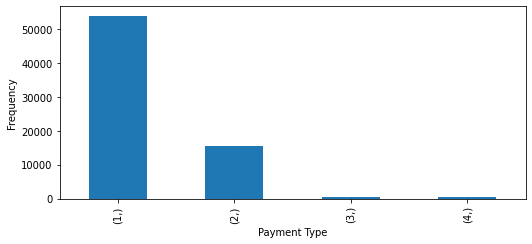

In [27]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

col = Y[0:70000]

df = pd.DataFrame(col)
df.value_counts().plot(ax=ax , kind='bar', xlabel='Payment Type', ylabel='Frequency')

plt.show()

In [28]:
# PRINT THE CORRELATION

tempName = "payment_type"

col2 = Y[0:70000]

print(Y_generate[0:70000].corrwith(col2))

0    0.003152
dtype: float64
